# Topic Modeling on 20 Newsgroups Dataset

This notebook implements topic modeling using Latent Dirichlet Allocation (LDA) on the 20 Newsgroups dataset. The analysis discovers latent topics in newsgroup posts and visualizes how documents cluster around these topics.

## Analysis Components

1. **Data Loading and Preprocessing**
   - Load raw text data
   - Clean and tokenize text
   - Remove stopwords and lemmatize

2. **Topic Modeling**
   - Build dictionary and document-term matrix
   - Train LDA model
   - Evaluate model coherence

3. **Visualizations**
   - Word clouds for each topic
   - t-SNE visualization of document-topic distributions
   - Interactive topic exploration

## Requirements
- Python 3.x
- NLTK, Gensim, WordCloud
- Pandas, NumPy, Matplotlib
- Scikit-learn

## Import Required Libraries
First, we'll import all the necessary libraries for data processing, modeling, and visualization.

In [14]:
# Standard libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLP and text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Topic modeling
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Dimensionality reduction
from sklearn.manifold import TSNE

# Set random seed for reproducibility
np.random.seed(42)

## Download NLTK Data
Download required NLTK datasets for text processing with error handling.

In [15]:
# Function to download NLTK data with error handling
def ensure_nltk_data():
    """Download required NLTK data if not already present"""
    required_data = ['punkt', 'wordnet', 'stopwords']
    
    for data in required_data:
        try:
            nltk.data.find(f'tokenizers/{data}' if data == 'punkt' else f'corpora/{data}')
            print(f"✓ {data} already downloaded")
        except LookupError:
            print(f"Downloading {data}...")
            nltk.download(data)
            print(f"✓ {data} download complete")

# Download required NLTK data
ensure_nltk_data()

✓ punkt already downloaded
✓ wordnet download complete
✓ stopwords already downloaded
✓ wordnet download complete
✓ stopwords already downloaded


[nltk_data] Downloading package wordnet to C:\Users\Devansh
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load and Prepare Dataset
Load the 20 Newsgroups dataset from the local directory and perform initial data exploration.

In [16]:
def load_20newsgroups_data(base_path):
    """
    Load the 20 Newsgroups dataset from a directory.
    
    Args:
        base_path (str): Path to the dataset directory
        
    Returns:
        pd.DataFrame: DataFrame containing 'text' and 'label' columns
    """
    texts = []
    labels = []
    
    # Validate path
    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Dataset directory not found at {base_path}")
    
    # Load data
    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                file_path = os.path.join(label_path, filename)
                try:
                    with open(file_path, 'r', encoding='latin1') as file:
                        texts.append(file.read())
                        labels.append(label)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    
    return pd.DataFrame({'label': labels, 'text': texts})

# Load dataset
base_path = "./Resources/20_newsgroups"
df = load_20newsgroups_data(base_path)

# Display dataset statistics
print("Dataset Statistics:")
print(f"Total documents: {len(df)}")
print(f"Number of newsgroups: {df['label'].nunique()}\n")
print("Documents per newsgroup:")
print(df['label'].value_counts())

Dataset Statistics:
Total documents: 19997
Number of newsgroups: 20

Documents per newsgroup:
label
alt.atheism                 1000
comp.graphics               1000
talk.politics.misc          1000
talk.politics.mideast       1000
talk.politics.guns          1000
sci.space                   1000
sci.med                     1000
sci.electronics             1000
sci.crypt                   1000
rec.sport.hockey            1000
rec.sport.baseball          1000
rec.motorcycles             1000
rec.autos                   1000
misc.forsale                1000
comp.windows.x              1000
comp.sys.mac.hardware       1000
comp.sys.ibm.pc.hardware    1000
comp.os.ms-windows.misc     1000
talk.religion.misc          1000
soc.religion.christian       997
Name: count, dtype: int64


## Text Preprocessing
Implement text preprocessing pipeline including:
- Tokenization
- Stopword removal
- Lemmatization
- Case normalization

In [17]:
# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess text by performing tokenization, stopword removal, and lemmatization.
    
    Args:
        text (str): Raw text to preprocess
        
    Returns:
        list: List of preprocessed tokens
    """
    # Convert to lowercase and tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and non-alphabetic tokens, then lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
             if token.isalpha() and token not in stop_words]
    
    return tokens

# Apply preprocessing to all documents
print("Preprocessing documents...")
df['tokens'] = df['text'].apply(preprocess_text)
print("Preprocessing complete!")

# Display sample
print("\nSample preprocessed document:")
print(df['tokens'].iloc[0][:50], "...")

Preprocessing documents...
Preprocessing complete!

Sample preprocessed document:
['xref', 'path', 'agate', 'uunet', 'pipex', 'ibmpcug', 'mantis', 'mathew', 'mathew', 'mathew', 'newsgroups', 'subject', 'faq', 'atheist', 'resource', 'summary', 'book', 'address', 'music', 'anything', 'related', 'atheism', 'keywords', 'faq', 'atheism', 'book', 'music', 'fiction', 'address', 'contact', 'date', 'mon', 'mar', 'gmt', 'expires', 'thu', 'apr', 'gmt', 'distribution', 'world', 'organization', 'mantis', 'consultant', 'cambridge', 'uk', 'approved', 'supersedes', 'line', 'resource', 'december'] ...
Preprocessing complete!

Sample preprocessed document:
['xref', 'path', 'agate', 'uunet', 'pipex', 'ibmpcug', 'mantis', 'mathew', 'mathew', 'mathew', 'newsgroups', 'subject', 'faq', 'atheist', 'resource', 'summary', 'book', 'address', 'music', 'anything', 'related', 'atheism', 'keywords', 'faq', 'atheism', 'book', 'music', 'fiction', 'address', 'contact', 'date', 'mon', 'mar', 'gmt', 'expires', 'thu', 'ap

## Create Dictionary and Corpus
Create a Gensim dictionary and document-term matrix (corpus) from the preprocessed texts.

In [18]:
# Create dictionary
dictionary = Dictionary(df['tokens'])

# Filter extreme frequencies
dictionary.filter_extremes(
    no_below=10,    # Keep tokens appearing in at least 10 documents
    no_above=0.5    # Keep tokens appearing in at most 50% of documents
)

# Create document-term matrix
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Print dictionary statistics
print("Dictionary Statistics:")
print(f"Number of unique tokens: {len(dictionary)}")
print(f"Number of documents: {len(corpus)}")

Dictionary Statistics:
Number of unique tokens: 16488
Number of documents: 19997


## Train and Evaluate LDA Model
Train the LDA model and evaluate its quality using topic coherence scores.

In [19]:
# Set LDA parameters
num_topics = 10
passes = 15

# Train LDA model
print("Training LDA model...")
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=passes,
    alpha='auto',    # Learn the asymmetric prior from data
    eta='auto',      # Learn the asymmetric prior from data
    random_state=42  # For reproducibility
)
print("Training complete!")

# Calculate coherence score
coherence_model = CoherenceModel(
    model=lda_model,
    texts=df['tokens'],
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

print(f"\nTopic Coherence Score: {coherence_score:.4f}")
print("(Scores closer to 1.0 indicate better topic quality)")

# Display topics
print("\nTop 10 words in each topic:")
topics = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)
for topic_id, topic_words in topics:
    words = ", ".join([word for word, _ in topic_words])
    print(f"\nTopic {topic_id}:")
    print(words)

Training LDA model...
Training complete!
Training complete!

Topic Coherence Score: 0.5587
(Scores closer to 1.0 indicate better topic quality)

Top 10 words in each topic:

Topic 0:
one, would, like, get, time, car, good, article, much, problem

Topic 1:
card, drive, system, apple, village, driver, board, monitor, problem, video

Topic 2:
would, people, one, right, think, article, like, say, know, could

Topic 3:
god, christian, one, jew, jesus, israel, say, may, u, would

Topic 4:
file, use, program, window, system, x, software, image, also, data

Topic 5:
news, uunet, cramer, article, xref, university, clayton, pipex, uknet, uk

Topic 6:
armenian, science, study, value, objective, human, armenia, state, year, turk

Topic 7:
q, x, r, p, max, g, n, w, c, e

Topic 8:
key, space, system, government, chip, new, public, encryption, clipper, security

Topic 9:
news, university, usenet, rochester, article, game, udel, gatech, xref, distribution

Topic Coherence Score: 0.5587
(Scores closer 

## Topic Visualization
### Word Clouds
Create word clouds to visualize the most significant words in each topic.

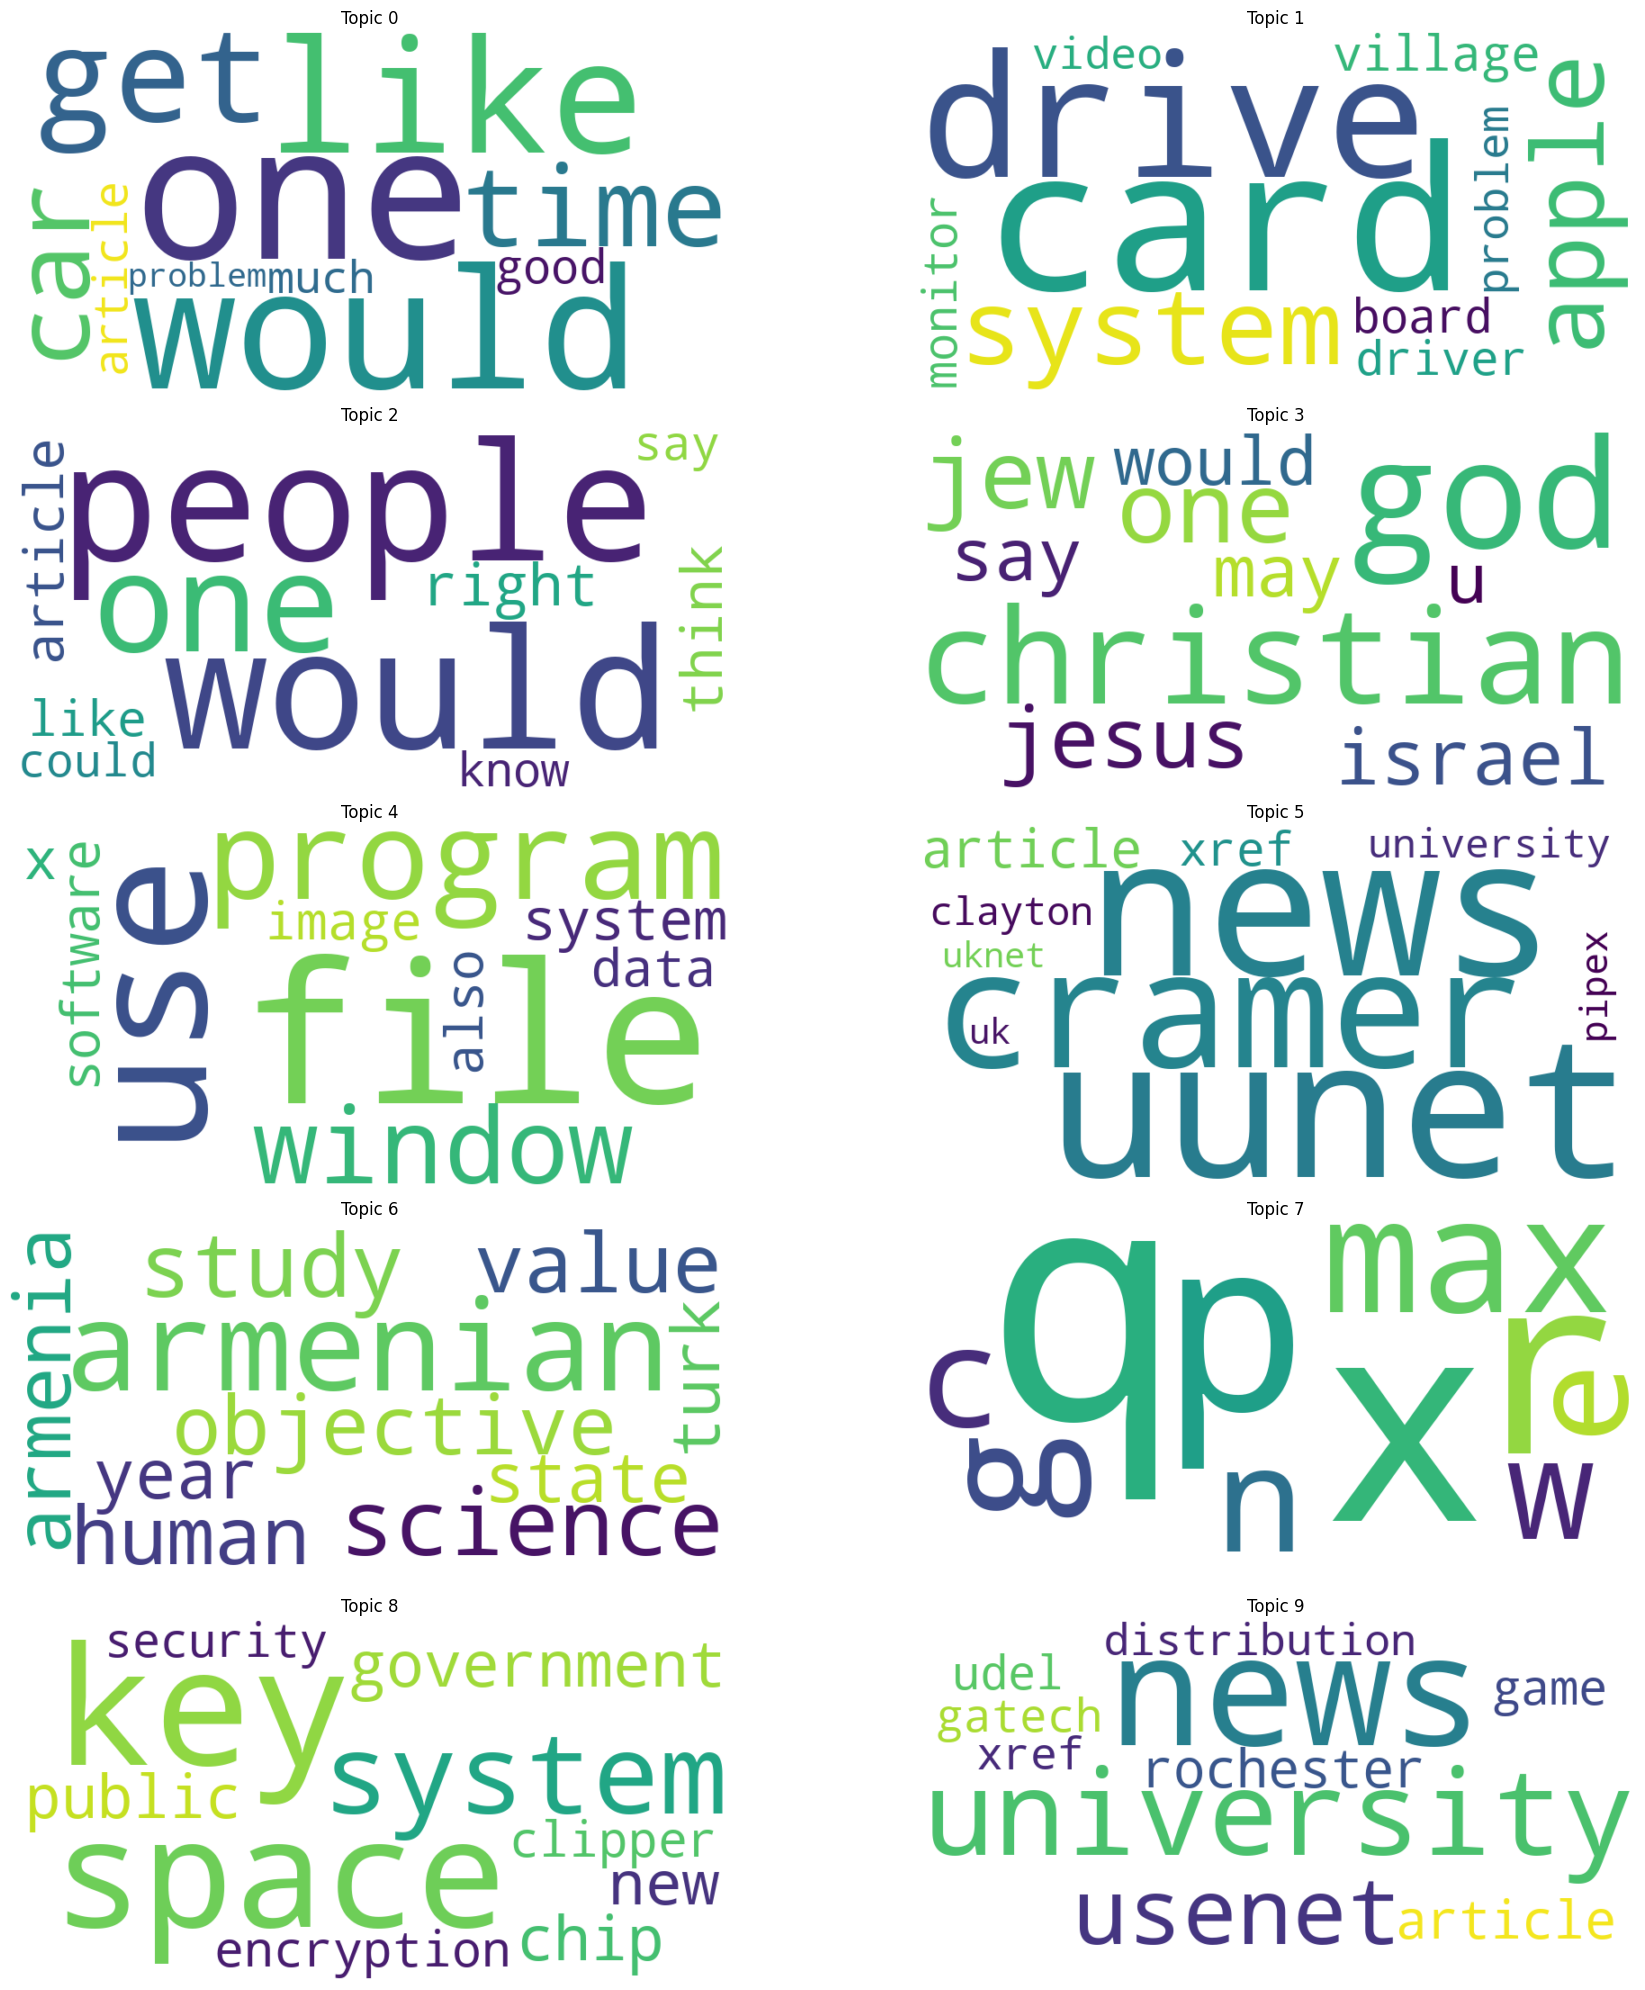

In [20]:
# Create word clouds for each topic
plt.figure(figsize=(20, 4*((num_topics+1)//2)))

for topic_id, topic_words in topics:
    plt.subplot((num_topics+1)//2, 2, topic_id+1)
    
    # Generate word cloud
    word_freq = {word: freq for word, freq in topic_words}
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(word_freq)
    
    # Display word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id}')

plt.tight_layout()
plt.show()

### Document Clustering Visualization
Create a t-SNE visualization to show how documents cluster by topic and newsgroup.

In [21]:
from sklearn.manifold import TSNE

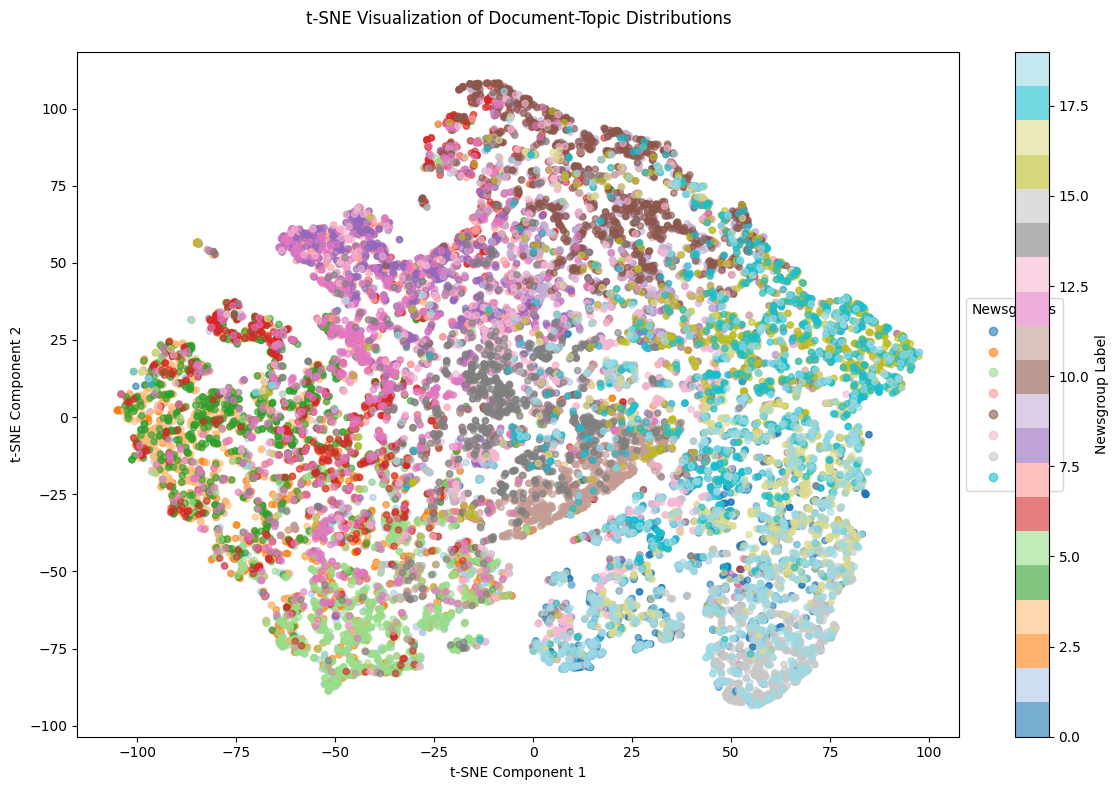

In [25]:
# Get document-topic distributions
topic_distributions = [lda_model.get_document_topics(doc, minimum_probability=0.0) 
                      for doc in corpus]
topic_vectors = np.array([[weight for _, weight in doc] for doc in topic_distributions])

# Configure and run t-SNE
# Configure and run t-SNE

# Configure and run t-SNE

# Configure and run t-SNE correctly
tsne_model = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    init='pca',
    learning_rate='auto',
    # n_iter=1000  # ✅ Pass here, not in fit_transform
)

# Fit and transform only once
tsne_lda = tsne_model.fit_transform(topic_vectors)

# Transform the data
tsne_lda = tsne_model.fit_transform(topic_vectors)

# Create visualization
plt.figure(figsize=(12, 8))

# Create scatter plot with newsgroup labels
scatter = plt.scatter(
    tsne_lda[:, 0],
    tsne_lda[:, 1],
    c=pd.factorize(df['label'])[0],
    cmap='tab20',
    s=20,              # Marker size
    alpha=0.6,         # Transparency
)

# Add legend
legend = plt.legend(*scatter.legend_elements(),
                   loc="center left",
                   bbox_to_anchor=(1, 0.5),
                   title="Newsgroups")

plt.colorbar(label='Newsgroup Label')
plt.title("t-SNE Visualization of Document-Topic Distributions", pad=20)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Adjust layout
plt.tight_layout()
plt.show()